# Random Forest approach
Random Forest (biopython) on phage & bacteria pairs 23*18 \
The random forest algorithm will try to make many prediction trees to obtain the best one; suitable since the input size for phage against bacteria is quite low.

To represent all minhashes more efficiently, I can construct a matrix with all possible minhashes as column names and all phage and bacteria names as rows 

## Minhash presence matrix 

In [1]:
# Setting up and obtaining unique minhashes

import sourmash, os
from tqdm import tqdm
import pandas as pd
import numpy as np
from io_operations import presence_matrix

raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
#for n in [50, 500, 5000, 10000, 50000]:
n = 500
k = 18

binary_matrix, entity_to_index, minhash_to_index, phage_minhash_data, bact_minhash_data = presence_matrix(n=n, k=k, TS=True)

Loading phage minhash sketches from: ../data_prod/SM_sketches/PhageMinhash_n500_k18_rev/
Loading bacteria minhash sketches from: ../data_prod/SM_sketches/BactMinhash_n500_k18_rev/

Unique minhashes extracted with len: 28895

Binary presence matrix created with shape: (133, 28895)
Sample rows (entities): ['Abuela', 'Amona', 'Crus', 'Echoes', 'FO3A_23_KMC_reoriented']
Sample columns (minhashes): [np.int64(90281211652), np.int64(278436322795), np.int64(405012416096), np.int64(470210724260), np.int64(482172228249)]


#### hostrange data for lookup 
(y value : target for RandomForest network)

In [2]:
from io_operations import call_hostrange_df
bact_lookup, host_range_df = call_hostrange_df(raw_data_path + "phagehost_KU/Hostrange_data_all_crisp_iso.xlsx")
print(bact_lookup)
display(host_range_df)

{'J14_21_reoriented': 'Acinetobacter calcoaceticus', 'J53_21_reoriented': 'Acinetobacter calcoaceticus', 'J105_22_reoriented': 'Chishuiella', 'J46_21_reoriented': 'Chryseobacterium', 'J50_21_reoriented': 'Chryseobacterium', 'J2264_1_22_KMC_reoriented': 'Chryseobacterium', 'J2264_3_22_KMC_reoriented': 'Chryseobacterium', 'J63_22_reoriented': 'Chryseobacterium', 'J64_22_reoriented': 'Chryseobacterium', 'J1_21_reoriented': 'Lelliottia', 'J91_22_reoriented': 'Lelliottia', 'J51_21_reoriented': 'Morganella morganii', 'J57_21_reoriented': 'Morganella morganii', 'J10_21_reoriented': 'Pectobacterium atrosepticum', 'J11_21_reoriented': 'Pectobacterium atrosepticum', 'J126_23_reoriented': 'Pectobacterium atrosepticum', 'J12_21_reoriented': 'Pectobacterium atrosepticum', 'J16_21_reoriented': 'Pectobacterium atrosepticum', 'J22_21_reoriented': 'Pectobacterium atrosepticum', 'J28_21_reoriented': 'Pectobacterium atrosepticum', 'J33_21_reoriented': 'Pectobacterium atrosepticum', 'J38_21_reoriented': '

,phage,Ymer,Taid,Poppous,Koroua,Abuela,Amona,Sabo,Mimer,Crus,...,Vims,Echoes,Galvinrad,Uther,Rip,Rup,Slaad,Pantea,Rap,Zann
0,J14_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J53_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J105_22_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J46_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J50_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,J109_23_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,J101_22_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,J15_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,800000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,J4_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Isolation host,Isolation host,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
from manipulations import hostrange_df_to_dict, binarize_host_range

# Convert the host range data into a dictionary
host_range_data = hostrange_df_to_dict(host_range_df)
host_range_data = binarize_host_range(host_range_data, continous=False) #for classification model

#host_range_data["J10_21_reoriented"]

## Running the Random Forest Classifier

In [4]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

phage_names = phage_minhash_data.keys()
bacteria_names = bact_minhash_data.keys()

In [5]:
X = []
y = []
rows_metadata = [] # To keep track of which entities form the row

# Iterate through all valid phage-bacteria pairs (the required pairwise iteration)
for bact_name in tqdm(bacteria_names, desc="Bacteria names iterated"):
    for phage_name in phage_names:
        # Get the interaction score (target variable y)
        try:
            interaction_score = host_range_data[bact_name][phage_name]
        except KeyError:
            continue

        # Get the feature vectors (rows from the incidence matrix)
        bact_index = entity_to_index[bact_name]
        phage_index = entity_to_index[phage_name]

        bact_features = binary_matrix[bact_index, :]
        phage_features = binary_matrix[phage_index, :]

        # Concatenate: [Bacterium Features | Phage Features]
        combined_features = np.concatenate((bact_features, phage_features))

        X.append(combined_features)
        y.append(interaction_score)
        #print(X)
        #print(y)
        rows_metadata.append((bact_name, phage_name))

X = np.array(X)
y = np.array(y)

print("Unique values found in y:", set(y))
print(f"Percent zeros in y: {round(([sum(val == 0 for val in y)][0]/len(y))*100,2)}%")

# Check if we have enough data to proceed
if X.shape[0] < 2:
    print(f"Error: Not enough data points ({X.shape[0]} found) for train-test split and Random Forest.")
    sys.exit(1)

Bacteria names iterated:   0%|          | 0/110 [00:00<?, ?it/s]

Bacteria names iterated: 100%|██████████| 110/110 [00:00<00:00, 431.04it/s]


Unique values found in y: {np.int64(0), np.int64(1)}
Percent zeros in y: 92.33%


In [6]:
# --- Perform Random Forest Run ---

# Generate indices to track rows through the split
indices = np.arange(len(X))

# Split X, y, and the original indices synchronously
# The split arguments (random_state, stratify) MUST be identical for X/y and indices
X_train, X_test, y_train, y_test, _, indices_test = train_test_split(
    X, y, indices, test_size=0.3, random_state=42
)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate and report the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Shape of the combined Feature Matrix X: {X.shape}")
print(f"Number of target variables y: {len(y)}")
print("\nRandom Forest Classification Results:")
print(f"Feature Vector Size (2 * number of unique minhashes): {X.shape[1]}")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Test Accuracy: {accuracy:.4f}")

# Create DataFrame to show test results and map back to entity names
test_results_df = pd.DataFrame({
    'Bacterium': [rows_metadata[i][0] for i in indices_test],
    'Phage': [rows_metadata[i][1] for i in indices_test],
    'Actual_Interaction': y_test,
    'Predicted_Interaction': y_pred
})

print("\nTest Set Predictions:")
display(test_results_df)

Shape of the combined Feature Matrix X: (2530, 57790)
Number of target variables y: 2530

Random Forest Classification Results:
Feature Vector Size (2 * number of unique minhashes): 57790
Training set size: 1771 samples
Testing set size: 759 samples
Test Accuracy: 0.9539

Test Set Predictions:


,Bacterium,Phage,Actual_Interaction,Predicted_Interaction
0,J128_23_reoriented,Uther,0,0
1,J51_21_reoriented,Galvinrad,0,0
2,J48_21_reoriented,Taid,0,0
3,J34_21_reoriented,Slaad,0,0
4,J12_21_reoriented,Guf,0,0
...,...,...,...,...
754,J19_21_reoriented,Slaad,0,0
755,J17_21_reoriented,Amona,0,0
756,J101_22_reoriented,Koroua,0,0
757,J6_21_reoriented,Abuela,0,0


### Model performance

#### ROC-curve

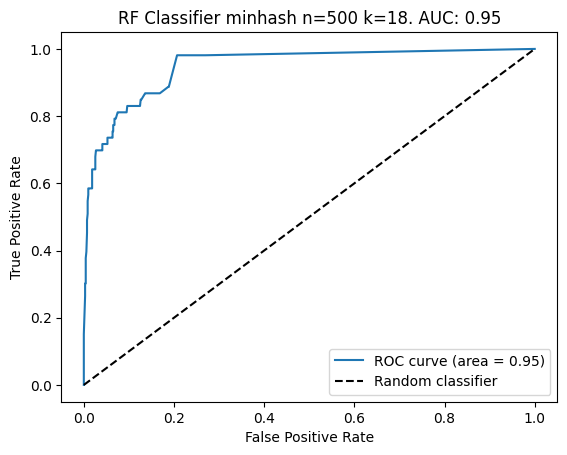

In [9]:
from analysis import plot_roc_curve_rf
plot_roc_curve_rf(rf_classifier, X_test, y_test, title=f"RF Classifier minhash n={n} k={k}", save=f"../fig/RF_ROC_n{n}.png")

[0.         0.         0.         0.00283286 0.00283286 0.00424929
 0.00424929 0.00424929 0.00566572 0.00708215 0.00708215 0.00849858
 0.00849858 0.00991501 0.00991501 0.01274788 0.01558074 0.0184136
 0.0184136  0.0184136  0.02266289 0.02549575 0.02549575 0.02691218
 0.02832861 0.03116147 0.0368272  0.03824363 0.04107649 0.04107649
 0.04674221 0.05240793 0.05240793 0.05665722 0.05949008 0.06232295
 0.06373938 0.06373938 0.06515581 0.06515581 0.06798867 0.06798867
 0.07082153 0.07507082 0.07648725 0.08215297 0.08356941 0.08640227
 0.09490085 0.09631728 0.09773371 0.10056657 0.101983   0.10481586
 0.11756374 0.12181303 0.12464589 0.12606232 0.12747875 0.13597734
 0.13739377 0.14305949 0.15155807 0.16288952 0.16855524 0.18696884
 0.18838527 0.20679887 0.21246459 0.21529745 0.26203966 0.26628895
 0.26912181 1.        ]
[0.         0.0754717  0.1509434  0.26415094 0.30188679 0.30188679
 0.32075472 0.37735849 0.39622642 0.45283019 0.49056604 0.50943396
 0.54716981 0.56603774 0.58490566 0.584

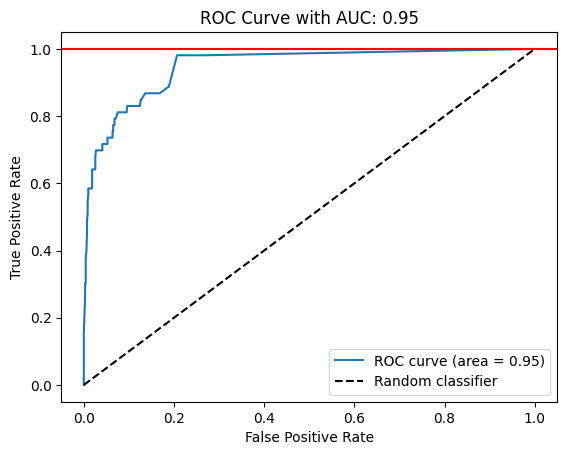

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = roc_auc_score(y_test, y_pred_prob)
#print(f"ROC AUC: {roc_auc}")

#print(y_pred_prob)
print(fpr)
print(tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
# roc curve for tpr = fpr 
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.axhline(1, color="red")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve with AUC: {round(roc_auc, 2)}')
plt.legend(loc="lower right")


In [ ]:
sys.exit(1)

SystemExit: 1

/Users/asbjornhansen/Library/Python/3.9/lib/python/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Running the Random Forest Regressor
Relies on earlier code for Random Forest Classifier\
Can be continous y data

#### hostrange data for lookup 
(y value : target for RandomForest network)

In [ ]:
from io_operations import call_hostrange_df
bact_lookup, host_range_df = call_hostrange_df(raw_data_path + "phagehost_KU/Hostrange_data_all_crisp_iso.xlsx")
print(bact_lookup)
display(host_range_df)

{'J14_21_reoriented': 'Acinetobacter calcoaceticus', 'J53_21_reoriented': 'Acinetobacter calcoaceticus', 'J105_22_reoriented': 'Chishuiella', 'J46_21_reoriented': 'Chryseobacterium', 'J50_21_reoriented': 'Chryseobacterium', 'J2264_1_22_KMC_reoriented': 'Chryseobacterium', 'J2264_3_22_KMC_reoriented': 'Chryseobacterium', 'J63_22_reoriented': 'Chryseobacterium', 'J64_22_reoriented': 'Chryseobacterium', 'J1_21_reoriented': 'Lelliottia', 'J91_22_reoriented': 'Lelliottia', 'J51_21_reoriented': 'Morganella morganii', 'J57_21_reoriented': 'Morganella morganii', 'J10_21_reoriented': 'Pectobacterium atrosepticum', 'J11_21_reoriented': 'Pectobacterium atrosepticum', 'J126_23_reoriented': 'Pectobacterium atrosepticum', 'J12_21_reoriented': 'Pectobacterium atrosepticum', 'J16_21_reoriented': 'Pectobacterium atrosepticum', 'J22_21_reoriented': 'Pectobacterium atrosepticum', 'J28_21_reoriented': 'Pectobacterium atrosepticum', 'J33_21_reoriented': 'Pectobacterium atrosepticum', 'J38_21_reoriented': '

,phage,Ymer,Taid,Poppous,Koroua,Abuela,Amona,Sabo,Mimer,Crus,...,Vims,Echoes,Galvinrad,Uther,Rip,Rup,Slaad,Pantea,Rap,Zann
0,J14_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J53_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J105_22_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J46_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J50_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,J109_23_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
106,J101_22_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107,J15_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,800000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,J4_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,Isolation host,Isolation host,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from manipulations import hostrange_df_to_dict, binarize_host_range

# Convert the host range data into a dictionary
host_range_data = hostrange_df_to_dict(host_range_df)
host_range_data = binarize_host_range(host_range_data, continous=True) #for regressor model

#host_range_data["J10_21_reoriented"]

In [ ]:
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

phage_names = phage_minhash_data.keys()
bacteria_names = bact_minhash_data.keys()

entity_to_index = {name: i for i, name in enumerate(entity_names)}
minhash_to_index = {minhash: i for i, minhash in enumerate(sorted_minhashes)}

In [ ]:
X = []
y = []
rows_metadata = [] # To keep track of which entities form the row

# Iterate through all valid phage-bacteria pairs (the required pairwise iteration)
for bact_name in tqdm(bacteria_names, desc="Bacteria names iterated"):
    for phage_name in phage_names:
        # Get the interaction score (target variable y)
        try:
            interaction_score = host_range_data[bact_name][phage_name]
        except KeyError:
            continue

        # Get the feature vectors (rows from the incidence matrix)
        bact_index = entity_to_index[bact_name]
        phage_index = entity_to_index[phage_name]

        bact_features = binary_matrix[bact_index, :]
        phage_features = binary_matrix[phage_index, :]

        # Concatenate: [Bacterium Features | Phage Features]
        combined_features = np.concatenate((bact_features, phage_features))

        X.append(combined_features)
        y.append(interaction_score)
        #print(X)
        #print(y)
        rows_metadata.append((bact_name, phage_name))

X = np.array(X)
y = np.array(y)

print("Unique values found in y:", set(y))
print(f"Percent zeros in y: {round(([sum(val == 0 for val in y)][0]/len(y))*100,2)}%")

# Check if we have enough data to proceed
if X.shape[0] < 2:
    print(f"Error: Not enough data points ({X.shape[0]} found) for train-test split and Random Forest.")
    sys.exit(1)

Bacteria names iterated: 100%|██████████| 110/110 [00:00<00:00, 620.93it/s]


Unique values found in y: {np.float64(0.0), np.float64(0.5614628680529818), np.float64(0.9452672735168459), np.float64(0.8676425494973266), np.float64(0.8093718170482997), np.float64(0.8455481814434052), np.float64(0.5250224534926693), np.float64(0.8687547728076501), np.float64(0.7081821388573444), np.float64(0.8108252811723454), np.float64(1.0), np.float64(0.8615564777146079), np.float64(0.5477551159067249), np.float64(0.5412948174532846), np.float64(0.907065782302784), np.float64(0.7077572583752069), np.float64(0.8990274275053132), np.float64(0.5454545849356269), np.float64(0.6161955747966705), np.float64(0.8905345470372451), np.float64(0.518088261174715), np.float64(0.5558130623979066), np.float64(0.6623847160448234), np.float64(0.9726336367582256), np.float64(0.43437804441480043), np.float64(0.6656563014010652), np.float64(0.534096531131664), np.float64(0.8263550101626268), np.float64(0.678399819351971), np.float64(0.8920830324277997), np.float64(0.9886419330357452), np.float64(0.8

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
# --- Perform Random Forest Run ---

# Generate indices to track rows through the split
indices = np.arange(len(X))

# Split X, y, and the original indices synchronously
# The split arguments (random_state, stratify) MUST be identical for X/y and indices
X_train, X_test, y_train, y_test, _, indices_test = train_test_split(
    X, y, indices, test_size=0.3, random_state=42
)

# Initialize and train the Random Forest Classifier
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Shape of the combined Feature Matrix X: {X.shape}")
print(f"Number of target variables y: {len(y)}")
print("\nRandom Forest Regression Results:")
print(f"Feature Vector Size (2 * unique minhashes): {X.shape[1]}")
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"Test R-squared (R2) Score: {r2:.4f}")
print(f"Test Mean Squared Error (MSE): {mse:.4f}")

# Create DataFrame to show test results and map back to entity names
test_results_df = pd.DataFrame({
    'Bacterium': [rows_metadata[i][0] for i in indices_test],
    'Phage': [rows_metadata[i][1] for i in indices_test],
    'Actual_Score': y_test,
    'Predicted_Score': y_pred
})

print("\nTest Set Predictions:")
display(test_results_df)

KeyboardInterrupt: 

### Model performance

In [ ]:
### Test for non-zero:
non_zero_pred_df = test_results_df[test_results_df["Predicted_Score"] > 0]
actual_non_zero = len(test_results_df[test_results_df["Actual_Score"]>0].index)
actual_zero = len(non_zero_pred_df.index) - actual_non_zero 

print(f"Non zero accuracy: {round(actual_non_zero / len(non_zero_pred_df.index)*100,2)}%")

Non zero accuracy: 37.06%


In [ ]:
import sys
sys.exit(1)

# Random Forest - iteratively / in batches

------- INITIATING RF FOR N=50, K=6 -------
Loading phage minhash sketches from: ../data_prod/SM_sketches/PhageMinhash_n50_k6_rev/
Loading bacteria minhash sketches from: ../data_prod/SM_sketches/BactMinhash_n50_k6_rev/

Unique minhashes extracted with len: 142

Binary presence matrix created with shape: (133, 142)
Sample rows (entities): ['Abuela', 'Amona', 'Crus', 'Echoes', 'FO3A_23_KMC_reoriented']
Sample columns (minhashes): [np.int64(22666275192454547), np.int64(22724158687659266), np.int64(24788289435301704), np.int64(30931011789596724), np.int64(45233239111635847)]


Bacteria names iterated: 100%|██████████| 110/110 [00:00<00:00, 24421.63it/s]


######## RESULTS COLLECTED FOR CSV ########

------- INITIATING RF FOR N=100, K=6 -------
Loading phage minhash sketches from: ../data_prod/SM_sketches/PhageMinhash_n100_k6_rev/
Loading bacteria minhash sketches from: ../data_prod/SM_sketches/BactMinhash_n100_k6_rev/

Unique minhashes extracted with len: 276

Binary presence matrix created with shape: (133, 276)
Sample rows (entities): ['Abuela', 'Amona', 'Crus', 'Echoes', 'FO3A_23_KMC_reoriented']
Sample columns (minhashes): [np.int64(22666275192454547), np.int64(22724158687659266), np.int64(24788289435301704), np.int64(30931011789596724), np.int64(45233239111635847)]


Bacteria names iterated: 100%|██████████| 110/110 [00:00<00:00, 26526.39it/s]


######## RESULTS COLLECTED FOR CSV ########

------- INITIATING RF FOR N=50, K=9 -------
Loading phage minhash sketches from: ../data_prod/SM_sketches/PhageMinhash_n50_k9_rev/
Loading bacteria minhash sketches from: ../data_prod/SM_sketches/BactMinhash_n50_k9_rev/

Unique minhashes extracted with len: 707

Binary presence matrix created with shape: (133, 707)
Sample rows (entities): ['Abuela', 'Amona', 'Crus', 'Echoes', 'FO3A_23_KMC_reoriented']
Sample columns (minhashes): [np.int64(207409549767498), np.int64(270699059392677), np.int64(295476197942292), np.int64(337048139476609), np.int64(390185231756022)]


Bacteria names iterated: 100%|██████████| 110/110 [00:00<00:00, 16400.89it/s]


######## RESULTS COLLECTED FOR CSV ########

------- INITIATING RF FOR N=100, K=9 -------
Loading phage minhash sketches from: ../data_prod/SM_sketches/PhageMinhash_n100_k9_rev/
Loading bacteria minhash sketches from: ../data_prod/SM_sketches/BactMinhash_n100_k9_rev/

Unique minhashes extracted with len: 1422

Binary presence matrix created with shape: (133, 1422)
Sample rows (entities): ['Abuela', 'Amona', 'Crus', 'Echoes', 'FO3A_23_KMC_reoriented']
Sample columns (minhashes): [np.int64(207409549767498), np.int64(270699059392677), np.int64(295476197942292), np.int64(337048139476609), np.int64(390185231756022)]


Bacteria names iterated: 100%|██████████| 110/110 [00:00<00:00, 9668.75it/s]


######## RESULTS COLLECTED FOR CSV ########



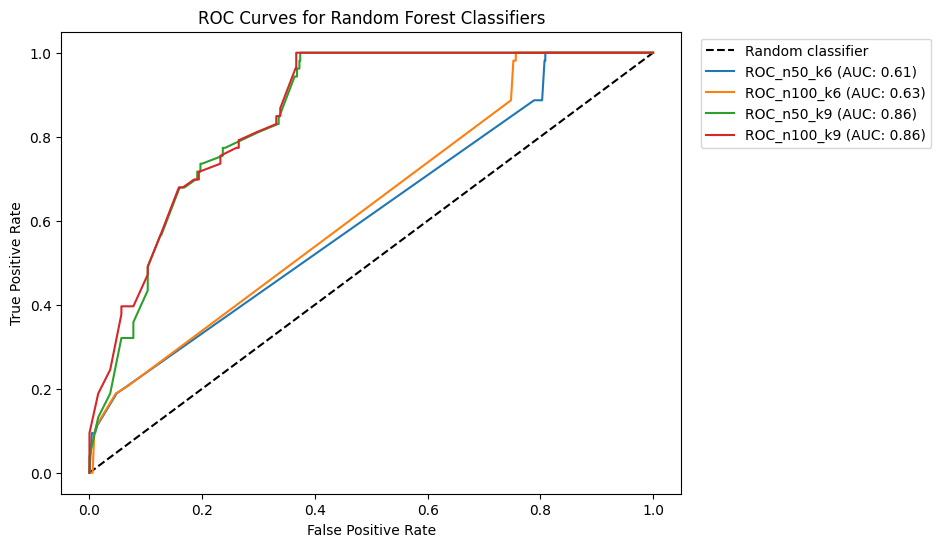

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from manipulations import clean_dict_keys, hostrange_df_to_dict, binarize_host_range
from io_operations import load_minhash_sketches, call_hostrange_df, presence_matrix

test_results_df = pd.DataFrame(columns=["Bacterium", "Phage", "Actual_Interaction", "Predicted_Interaction"])

raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
log_path = "../logs/"
logfile = log_path + "random_forest_batches.txt"

with open(logfile, "w") as log:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot([0, 1], [0, 1], 'k--', label='Random classifier')

    for k in [6, 9]:
        for n in [50, 100]:
    # for k in [6, 9, 12, 15, 18, 24]:
    #     for n in [50, 100, 500, 1000, 5000]:
            print(f"------- INITIATING RF FOR N={n}, K={k} -------")
            print(f"------- INITIATING RF FOR N={n}, K={k} -------", file=log)
            binary_matrix, entity_to_index, minhash_to_index, phage_minhash_data, bact_minhash_data = presence_matrix(n=n, k=k, TS=True)
            
            bact_lookup, host_range_df = call_hostrange_df(raw_data_path + "phagehost_KU/Hostrange_data_all_crisp_iso.xlsx")

            # Convert the host range data into a dictionary
            host_range_data = hostrange_df_to_dict(host_range_df)
            host_range_data = binarize_host_range(host_range_data, continous=False) #for classification model

            phage_names = phage_minhash_data.keys()
            bacteria_names = bact_minhash_data.keys()

            X = []
            y = []
            rows_metadata = [] # To keep track of which entities form the row

            # Iterate through all valid phage-bacteria pairs (the required pairwise iteration)
            for bact_name in tqdm(bacteria_names, desc="Bacteria names iterated"):
                for phage_name in phage_names:
                    # Get the interaction score (target variable y)
                    try:
                        interaction_score = host_range_data[bact_name][phage_name]
                    except KeyError:
                        continue

                    # Get the feature vectors (rows from the incidence matrix)
                    bact_index = entity_to_index[bact_name]
                    phage_index = entity_to_index[phage_name]

                    bact_features = binary_matrix[bact_index, :]
                    phage_features = binary_matrix[phage_index, :]

                    # Concatenate: [Bacterium Features | Phage Features]
                    combined_features = np.concatenate((bact_features, phage_features))

                    X.append(combined_features)
                    y.append(interaction_score)
                    #print(X)
                    #print(y)
                    rows_metadata.append((bact_name, phage_name))

            X = np.array(X)
            y = np.array(y)

            print("Unique values found in y:", set(y), file=log)
            print(f"Percent zeros in y: {round(([sum(val == 0 for val in y)][0]/len(y))*100,2)}%", file=log)

            # Check if we have enough data to proceed
            if X.shape[0] < 2:
                print(f"Error: Not enough data points ({X.shape[0]} found) for train-test split and Random Forest.", file=log)
                sys.exit(1)

            # --- Perform Random Forest Run ---

            # Generate indices to track rows through the split
            indices = np.arange(len(X))

            # Split X, y, and the original indices synchronously
            # The split arguments (random_state, stratify) MUST be identical for X/y and indices
            X_train, X_test, y_train, y_test, _, indices_test = train_test_split(
                X, y, indices, test_size=0.3, random_state=42
            )

            # Initialize and train the Random Forest Classifier
            rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
            rf_classifier.fit(X_train, y_train)

            # Make predictions on the test set
            y_pred = rf_classifier.predict(X_test)

            # Calculate and report the accuracy
            accuracy = accuracy_score(y_test, y_pred)

            # ROC Curve Plotting
            y_pred_prob = rf_classifier.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
            roc_auc = roc_auc_score(y_test, y_pred_prob)
            #print(f"ROC AUC: {roc_auc}")

            ax.plot(fpr, tpr, label=f'ROC_n{n}_k{k} (AUC: {roc_auc:.2f})')

            print(f"\n------- RESULTS FOR N={n}, K={k} -------", file=log)
            print(f"Shape of the combined Feature Matrix X: {X.shape}", file=log)
            print(f"Number of target variables y: {len(y)}", file=log)
            print("\nRandom Forest Classification Results:", file=log)
            print(f"Feature Vector Size (2 * number of unique minhashes): {X.shape[1]}", file=log)
            print(f"Training set size: {X_train.shape[0]} samples", file=log)
            print(f"Testing set size: {X_test.shape[0]} samples", file=log)
            print(f"Test Accuracy: {accuracy:.4f}", file=log)
            print(f"AUC : {roc_auc:.4f}", file=log)

            # Create DataFrame to show test results and map back to entity names
            test_results_df = pd.concat([test_results_df, pd.DataFrame({
                'Bacterium': [rows_metadata[i][0] for i in indices_test],
                'Phage': [rows_metadata[i][1] for i in indices_test],
                'Actual_Interaction': y_test,
                'Predicted_Interaction': y_pred
            })])
            print(f"######## RESULTS COLLECTED FOR CSV ########\n", file=log)
            print(f"######## RESULTS COLLECTED FOR CSV ########\n")

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curves for Random Forest Classifiers')
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.savefig("../fig/RF_ROC_batch.png")
test_results_df.to_csv(data_prod_path+"RandomForest.csv")

### Plot AUC bar graphs

In [12]:
ROC_dict = {
    'ROC_n50_k6': 0.61,
    'ROC_n100_k6': 0.63,
    'ROC_n500_k6': 0.77,
    'ROC_n1000_k6': 0.79,
    'ROC_n5000_k6': 0.82,
    'ROC_n50_k9': 0.86,
    'ROC_n100_k9': 0.86,
    'ROC_n500_k9': 0.86,
    'ROC_n1000_k9': 0.88,
    'ROC_n5000_k9': 0.94,
    'ROC_n50_k12': 0.96,
    'ROC_n100_k12': 0.96,
    'ROC_n500_k12': 0.97,
    'ROC_n1000_k12': 0.94,
    'ROC_n5000_k12': 0.94,
    'ROC_n50_k15': 0.96,
    'ROC_n100_k15': 0.90,
    'ROC_n500_k15': 0.95,
    'ROC_n1000_k15': 0.94,
    'ROC_n5000_k15': 0.96,
    'ROC_n50_k18': 0.95,
    'ROC_n100_k18': 0.96,
    'ROC_n500_k18': 0.95,
    'ROC_n1000_k18': 0.95,
    'ROC_n5000_k18': 0.95,
    'ROC_n50_k24': 0.96,
    'ROC_n100_k24': 0.97,
    'ROC_n500_k24': 0.96,
    'ROC_n1000_k24': 0.96,
    'ROC_n5000_k24': 0.97
}

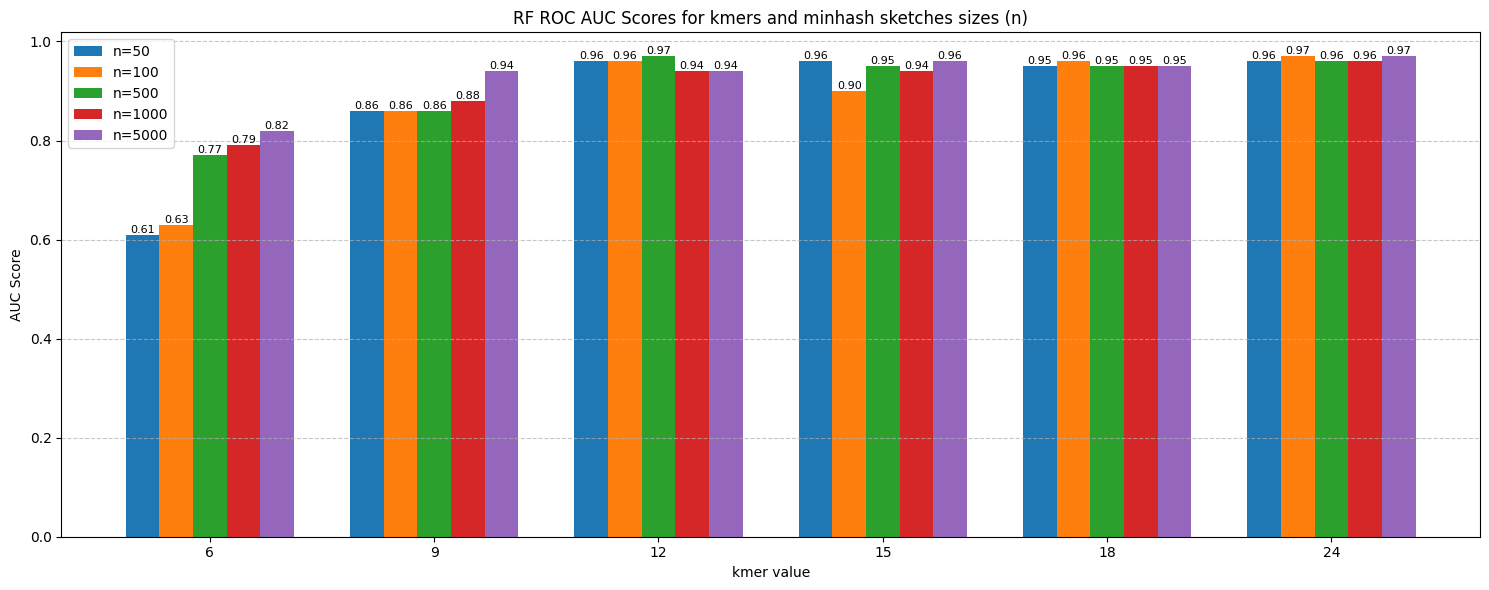

In [22]:
import numpy as np

import matplotlib.pyplot as plt

# Group by k values
k_values = [6, 9, 12, 15, 18, 24]
n_values = [50, 100, 500, 1000, 5000]

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Set the width of each bar and positions of the bars
bar_width = 0.15
r = np.arange(len(k_values))

# Plot bars for each n value
for i, n in enumerate(n_values):
    auc_values = [ROC_dict[f'ROC_n{n}_k{k}'] for k in k_values]
    ax.bar(r + i * bar_width, auc_values, bar_width, label=f'n={n}')

# Customize the plot
ax.set_xlabel('kmer value')
ax.set_ylabel('AUC Score')
ax.set_title('RF ROC AUC Scores for kmers and minhash sketches sizes (n)')
ax.set_xticks(r + bar_width * 2)
ax.set_xticklabels(k_values)
ax.legend()

# Add value labels on top of each bar
for i, n in enumerate(n_values):
    auc_values = [ROC_dict[f'ROC_n{n}_k{k}'] for k in k_values]
    for x, y in zip(r + i * bar_width, auc_values):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)


# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

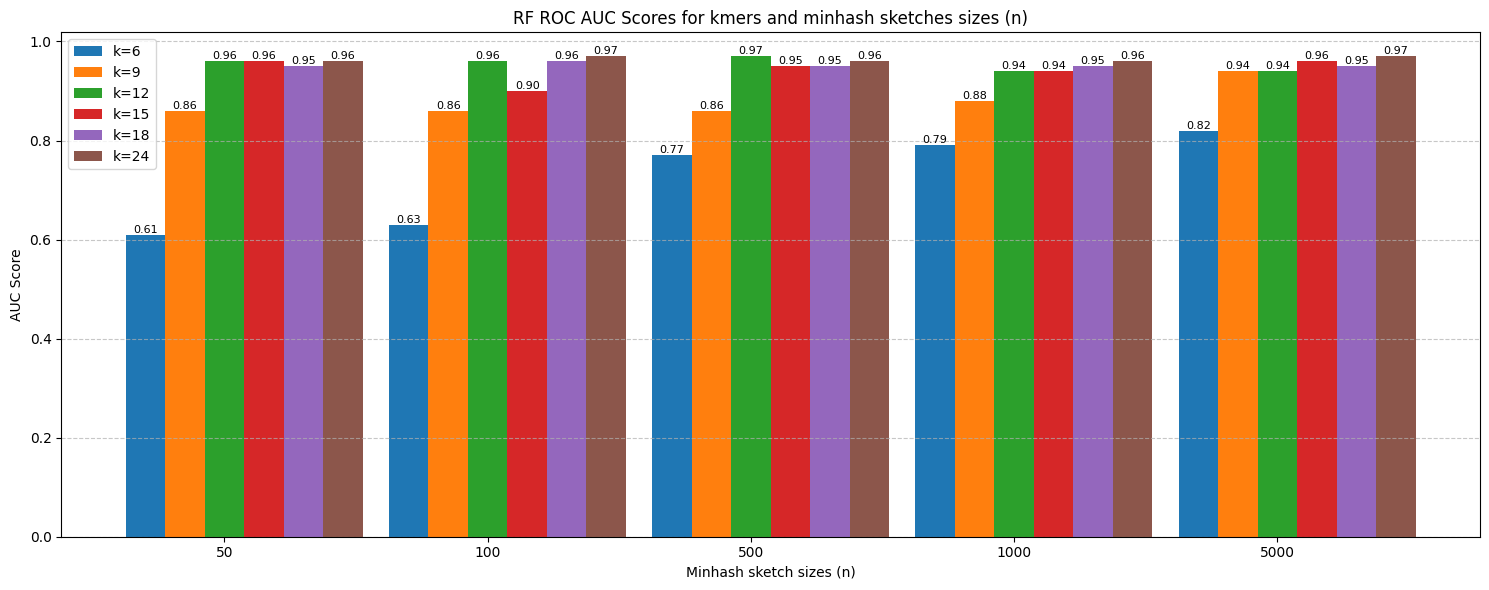

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Group by n values
k_values = [6, 9, 12, 15, 18, 24]
n_values = [50, 100, 500, 1000, 5000]

# Set up the plot
fig, ax = plt.subplots(figsize=(15, 6))

# Set the width of each bar and positions of the bars
bar_width = 0.15
r = np.arange(len(n_values))

# Plot bars for each k value
for i, k in enumerate(k_values):
    auc_values = [ROC_dict[f'ROC_n{n}_k{k}'] for n in n_values]
    ax.bar(r + i * bar_width, auc_values, bar_width, label=f'k={k}')

# Customize the plot
ax.set_xlabel('Minhash sketch sizes (n)')
ax.set_ylabel('AUC Score')
ax.set_title('RF ROC AUC Scores for kmers and minhash sketches sizes (n)')
ax.set_xticks(r + bar_width * 2)
ax.set_xticklabels(n_values)
ax.legend()

# Add value labels on top of each bar
for i, k in enumerate(k_values):
    auc_values = [ROC_dict[f'ROC_n{n}_k{k}'] for n in n_values]
    for x, y in zip(r + i * bar_width, auc_values):
        ax.text(x, y, f'{y:.2f}', ha='center', va='bottom', fontsize=8)

# Add grid for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

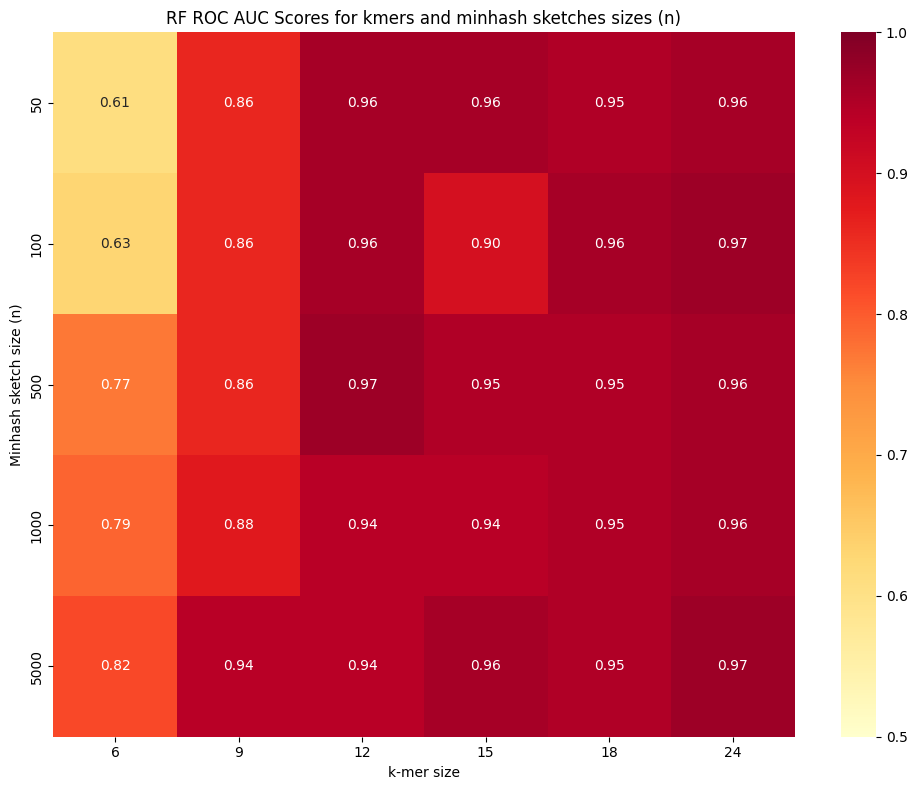

In [23]:
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Extract k and n values
k_values = [6, 9, 12, 15, 18, 24]
n_values = [50, 100, 500, 1000, 5000]

# Create a matrix for the heatmap
heatmap_data = np.zeros((len(n_values), len(k_values)))

# Fill the matrix with AUC values
for i, n in enumerate(n_values):
    for j, k in enumerate(k_values):
        key = f'ROC_n{n}_k{k}'
        heatmap_data[i, j] = ROC_dict[key]

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, 
            annot=True, 
            fmt='.2f', 
            cmap='YlOrRd',
            xticklabels=k_values,
            yticklabels=n_values,
            vmin=0.5,
            vmax=1.0)

plt.xlabel('k-mer size')
plt.ylabel('Minhash sketch size (n)')
plt.title('RF ROC AUC Scores for kmers and minhash sketches sizes (n)')

# Adjust layout to prevent label cutoff
plt.tight_layout()